In [32]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
train_data = pd.read_csv(r"/content/incidents_train.csv")
from google.colab import files
uploaded = files.upload()
test_data = pd.read_csv(r"/content/incidents.csv")

Saving incidents_train.csv to incidents_train.csv


Saving incidents.csv to incidents.csv


In [33]:
import os
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import zipfile

Cleaned Training Data Sample:
   Unnamed: 0  year  month  day country                          title  \
0           0  1994      1    7      us  recall notification fsis02494   
1           1  1994      3   10      us  recall notification fsis03394   
2           2  1994      3   28      us  recall notification fsis01494   
3           3  1994      4    3      us  recall notification fsis00994   
4           4  1994      7    1      us  recall notification fsis00194   

                                                text hazard-category  \
0  case number 02494                date opened 0...      biological   
1  case number 03394                date opened 1...      biological   
2  case number 01494                date opened 0...      biological   
3  case number 00994                date opened 0...  foreign bodies   
4  case number 00194                date opened 0...  foreign bodies   

               product-category                  hazard  \
0  meat, egg and dairy products  

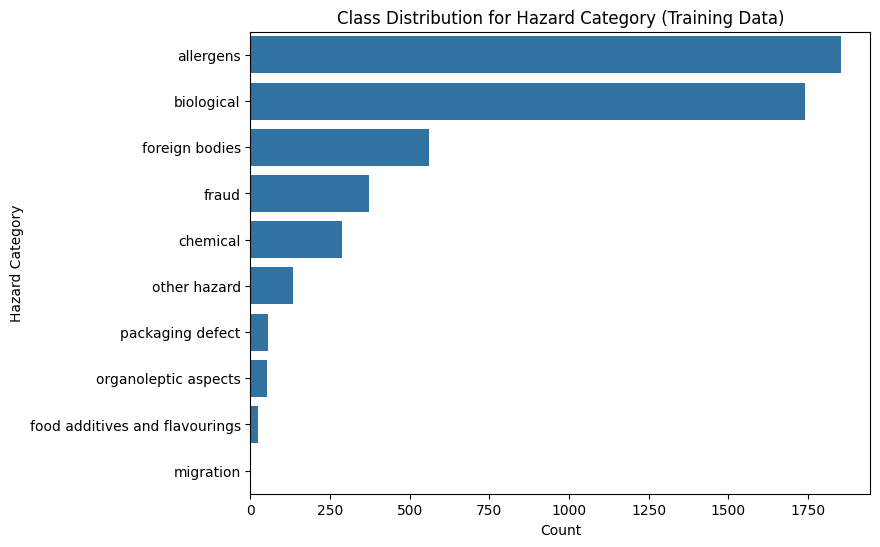

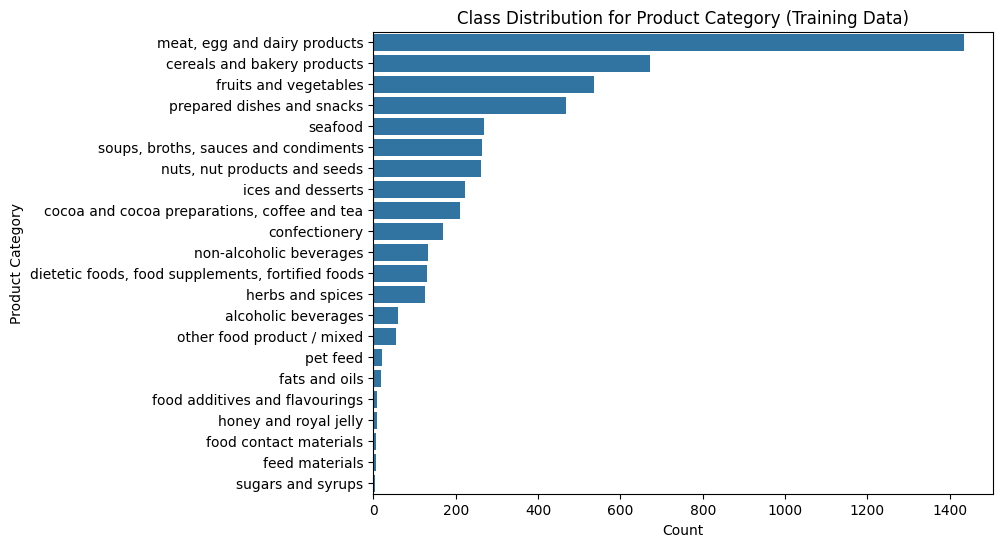

In [34]:
def clean_text(text):
    """
    Cleans the input text by removing special characters, converting to lowercase,
    and removing stopwords.
    """
    text = str(text)
    text = re.sub(r'\n', ' ', text)  # Replacing newlines with space
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Removing special characters
    text = text.lower()  # Converting to lowercase
    return text.strip()

# Cleaning 'title' and 'text' columns
train_data['title'] = train_data['title'].apply(clean_text)
train_data['text'] = train_data['text'].apply(clean_text)
test_data['title'] = test_data['title'].apply(clean_text)
test_data['text'] = test_data['text'].apply(clean_text)

# Displaying Cleaned Data Samples
print("Cleaned Training Data Sample:")
print(train_data.head())
print("\nCleaned Testing Data Sample:")
print(test_data.head())

# Visualizations
plt.figure(figsize=(8, 6))
sns.countplot(y='hazard-category', data=train_data, order=train_data['hazard-category'].value_counts().index)
plt.title("Class Distribution for Hazard Category (Training Data)")
plt.xlabel("Count")
plt.ylabel("Hazard Category")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(y='product-category', data=train_data, order=train_data['product-category'].value_counts().index)
plt.title("Class Distribution for Product Category (Training Data)")
plt.xlabel("Count")
plt.ylabel("Product Category")
plt.show()

In [ ]:
# Evaluation Function
def evaluate_model(y_true, y_pred):
    """
    Evaluates the model's performance using accuracy, precision, recall, and F1 score.
    """
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

# Compressing CSV Files
def compress_csv_files(folder, output_zip):
    """
    Compresses all CSV files in the specified folder into a single ZIP archive.
    """
    with zipfile.ZipFile(output_zip, "w") as zipf:
        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith(".csv"):
                    zipf.write(os.path.join(root, file), arcname=file)
    print(f"All predictions saved to {output_zip}")

# ST1 Task
features = ['title', 'text']
tasks_ST1 = ['hazard-category', 'product-category']
models = ['logistic_regression', 'xgboost']

def train_model_st1(X_train, X_valid, y_train, y_valid, model_type):
    """
    Training function for ST1 task.
    Handles encoding, vectorization, and model training.
    """
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_valid_encoded = label_encoder.transform(y_valid)

    vectorizer = TfidfVectorizer(max_features=300)
    X_train_vec = vectorizer.fit_transform(X_train).toarray()
    X_valid_vec = vectorizer.transform(X_valid).toarray()

    if model_type == 'logistic_regression':
        model = LogisticRegression(max_iter=300, class_weight='balanced')
    elif model_type == 'xgboost':
        model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, verbosity=0)

    model.fit(X_train_vec, y_train_encoded)
    y_pred = model.predict(X_valid_vec)
    metrics = evaluate_model(y_valid_encoded, y_pred)
    return model, metrics, label_encoder, vectorizer

# Predicting Test Data
def predict_test_data(test_data, feature, model, label_encoder, vectorizer):
    """
    Predicts the test data using the trained model and vectorizer.
    Decodes predictions using the provided label encoder.
    """
    X_test_vec = vectorizer.transform(test_data[feature]).toarray()
    predictions = model.predict(X_test_vec)
    return label_encoder.inverse_transform(predictions)

# ST1 Execution
os.makedirs("predictions_ST1", exist_ok=True)

for feature in features:
    for model_type in models:
        print(f"Running ST1 using {feature} with {model_type}")
        predictions = pd.DataFrame()

        for target in tasks_ST1:
            print(f"  Processing target: {target}")
            X_train, X_valid, y_train, y_valid = train_test_split(
                train_data[feature], train_data[target], test_size=0.2, random_state=42
            )
            model, metrics, label_encoder, vectorizer = train_model_st1(X_train, X_valid, y_train, y_valid, model_type)
            print(f"    Metrics for {target}: {metrics}")
            test_predictions = predict_test_data(test_data, feature, model, label_encoder, vectorizer)
            predictions[target] = test_predictions

        predictions.to_csv(f"predictions_ST1/ST1_{feature}_{model_type}_submission.csv", index=False)

compress_csv_files("predictions_ST1", "predictions_ST1.zip")


Running ST1 using title with logistic_regression
  Processing target: hazard-category
    Metrics for hazard-category: {'accuracy': 0.7138643067846607, 'precision': 0.7868751041533754, 'recall': 0.7138643067846607, 'f1_score': 0.7440041436425443}
  Processing target: product-category
    Metrics for product-category: {'accuracy': 0.5398230088495575, 'precision': 0.6422102678222392, 'recall': 0.5398230088495575, 'f1_score': 0.5767347187928015}
Running ST1 using title with xgboost
  Processing target: hazard-category
    Metrics for hazard-category: {'accuracy': 0.7826941986234022, 'precision': 0.7738458022893466, 'recall': 0.7826941986234022, 'f1_score': 0.7646984387667061}
  Processing target: product-category
    Metrics for product-category: {'accuracy': 0.5899705014749262, 'precision': 0.5728279836898515, 'recall': 0.5899705014749262, 'f1_score': 0.564207200963315}
Running ST1 using text with logistic_regression
  Processing target: hazard-category
    Metrics for hazard-category: {

In [ ]:
# Evaluation Function
def evaluate_model(y_true, y_pred):
    """
    Evaluates the model's performance using accuracy, precision, recall, and F1 score.
    """
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='weighted', zero_division=0),
    }

# Compressing CSV Files
def compress_csv_files(folder, output_zip):
    """
    Compresses all CSV files in the specified folder into a single ZIP archive.
    """
    with zipfile.ZipFile(output_zip, "w") as zipf:
        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith(".csv"):
                    zipf.write(os.path.join(root, file), arcname=file)
    print(f"All predictions saved to {output_zip}")

# Handling Rare Classes
def handle_rare_classes(data, target, threshold=2):
    """
    Merges rare classes with fewer than `threshold` instances into a new 'other' category.
    """
    class_counts = data[target].value_counts()
    rare_classes = class_counts[class_counts < threshold].index
    data[target] = data[target].replace(rare_classes, 'other')
    return data

# Training Model for ST2
def train_model_st2(X_train, X_valid, y_train, y_valid, model_type):
    """
    Train a model for ST2 tasks with label encoding.
    """
    # Combining labels for unseen categories
    all_labels = pd.concat([y_train, y_valid], axis=0).unique()
    label_mapping = {label: idx for idx, label in enumerate(sorted(all_labels))}
    num_classes = len(label_mapping)

    y_train_mapped = y_train.map(label_mapping)
    y_valid_mapped = y_valid.map(label_mapping)

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=300)
    X_train_vec = vectorizer.fit_transform(X_train).toarray()
    X_valid_vec = vectorizer.transform(X_valid).toarray()

    # Model Selection
    if model_type == 'logistic_regression':
        model = LogisticRegression(max_iter=300, class_weight='balanced')
    elif model_type == 'xgboost':
        model = XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            use_label_encoder=False,
            verbosity=0,
            num_class=num_classes  # Specifying number of classes
        )

    # Training the model
    model.fit(X_train_vec, y_train_mapped)

    # Predicting and evaluating
    y_pred = model.predict(X_valid_vec)
    metrics = evaluate_model(y_valid_mapped, y_pred)

    return model, metrics, vectorizer, label_mapping

# Predicting Test Data for ST2
def predict_test_data_st2(test_data, feature, model, vectorizer, label_mapping):
    """
    Predicts the test data using the trained model and vectorizer.
    Decodes predictions using the label mapping.
    """
    X_test_vec = vectorizer.transform(test_data[feature]).toarray()
    predictions = model.predict(X_test_vec)
    inv_label_mapping = {v: k for k, v in label_mapping.items()}
    return pd.Series(predictions).map(inv_label_mapping)

# Running ST2
def run_st2(train_data, test_data):
    """
    Executes ST2 pipeline: preprocessing, training, prediction, and saving results.
    """
    features = ['title', 'text']
    tasks = ['hazard', 'product']
    models = ['logistic_regression', 'xgboost']

    # Ensuring predictions folder exists
    os.makedirs("predictions_ST2", exist_ok=True)

    # Iterating through features and models
    for feature in features:
        for model_type in models:
            print(f"Running ST2 using {feature} with {model_type}")
            predictions = pd.DataFrame()

            # Iterating through tasks
            for target in tasks:
                print(f"  Processing target: {target}")

                # Handling rare classes
                train_data = handle_rare_classes(train_data, target, threshold=2)

                # Stratified splitting
                splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
                train_idx, valid_idx = next(splitter.split(train_data[feature], train_data[target]))
                X_train, X_valid = train_data[feature].iloc[train_idx], train_data[feature].iloc[valid_idx]
                y_train, y_valid = train_data[target].iloc[train_idx], train_data[target].iloc[valid_idx]

                # Training and evaluating the model
                model, metrics, vectorizer, label_mapping = train_model_st2(
                    X_train, X_valid, y_train, y_valid, model_type
                )
                print(f"    Metrics for {target}: {metrics}")

                # Predicting on test data
                test_predictions = predict_test_data_st2(
                    test_data, feature, model, vectorizer, label_mapping
                )
                predictions[target] = test_predictions

            # Saving predictions
            predictions.to_csv(f"predictions_ST2/ST2_{feature}_{model_type}_submission.csv", index=False)

    # Compressing results
    compress_csv_files("predictions_ST2", "predictions_ST2.zip")

# Running the ST2 task
run_st2(train_data, test_data)



Running ST2 using title with logistic_regression
  Processing target: hazard
    Metrics for hazard: {'accuracy': 0.34513274336283184, 'precision': 0.6659975506732924, 'recall': 0.34513274336283184, 'f1_score': 0.4154879084195876}
  Processing target: product
    Metrics for product: {'accuracy': 0.16125860373647985, 'precision': 0.21373203165238566, 'recall': 0.16125860373647985, 'f1_score': 0.14973863403066945}
Running ST2 using title with xgboost
  Processing target: hazard
    Metrics for hazard: {'accuracy': 0.5408062930186824, 'precision': 0.5167137002179832, 'recall': 0.5408062930186824, 'f1_score': 0.5161204974154308}
  Processing target: product
    Metrics for product: {'accuracy': 0.3087512291052114, 'precision': 0.27539544761197393, 'recall': 0.3087512291052114, 'f1_score': 0.27286757209099477}
Running ST2 using text with logistic_regression
  Processing target: hazard
    Metrics for hazard: {'accuracy': 0.34513274336283184, 'precision': 0.5686639876629213, 'recall': 0.345

In [ ]:
st1_file = "/content/predictions_ST1/ST1_text_xgboost_submission.csv"
st2_file = "/content/predictions_ST2/ST2_text_xgboost_submission.csv"

if not os.path.exists(st1_file):
    raise FileNotFoundError(f"{st1_file} not found.")
if not os.path.exists(st2_file):
    raise FileNotFoundError(f"{st2_file} not found.")

# Loading the CSV files into DataFrames
st1_df = pd.read_csv(st1_file)
st2_df = pd.read_csv(st2_file)

# Processing and merging the DataFrames
st1_df = st1_df[['hazard-category', 'product-category']]
st2_df = st2_df[['hazard', 'product']]
merged_df = pd.concat([st1_df, st2_df], axis=1)

# Adding a sequential column
merged_df.insert(0, ' ', range(1, len(merged_df) + 1))

# Saving the merged DataFrame
submission_file = "submission.csv"
merged_df.to_csv(submission_file, index=False)

# Zipping the submission file
zip_file_name = "submission.zip"
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    zipf.write(submission_file)

print(f"Merged submission saved as {submission_file}")
print(f"Zipped submission saved as {zip_file_name}")


Merged submission saved as submission.csv
Zipped submission saved as submission.zip
